# Part I. One-sided finite differences

Write a function, `deriv`, which computes a derivative of its argument at a given point, $x$, using a one-sided finite difference rule with a given step side $h$, with the approximation order of $O(h^2)$. 

In [38]:
def deriv(f, x, h):
    """ Compute a derivative of `f` at point `x` with step size `h`.
    
    Compute the derivative using the one-sided rule of the approximation order of $O(h^2)$.
    
    Parameters
    ----------
    f : callable
        The function to differentiate
    x : float
        The point to compute the derivative at.
    h : float
        The step size for the finite different rule.
        
    Returns
    -------
    fder : derivative of f(x) at point x using the step size h.
    """
    return (-1.5*f(x)-0.5*f(x+2*h)+2*f(x+h))/h

#### Test I.1

Test your function on a simple test case: differentiate $f(x) = x^3$ at $x=0$. Comment on whether your results are consistent with the expected value of $f'(x) = 0$ and on an expected scaling with $h\to 0$.

 (10% of the total grade)

In [39]:
x = 0
for h in [1e-2, 1e-3, 1e-4, 1e-5]:
    err = deriv(lambda x: x**3, x, h)
    print("%5f -- %7.4g" % (h, err))

0.010000 -- -0.0002
0.001000 --  -2e-06
0.000100 --  -2e-08
0.000010 --  -2e-10


Ошибка кавдратично заивисит

### Test I.2

Now use a slightly more complicated function, $f(x) = x^2 \log{x}$, evaluate the derivative at $x=1$ using your one-sided rule and a two-point one-sided rule. Roughly estimate the value of $h$ where the error stops decreasing, for these two schemes. 
(15% of the total grade)

In [40]:
from math import log
from matplotlib import pyplot as plt
import numpy as np


def f(x):
    return x**2 * log(x)
    
def fder(x):
    return x * (2.*log(x) + 1)

In [41]:
def deriv_2(f,x,h):
    return (f(x+h)-f(x))/h

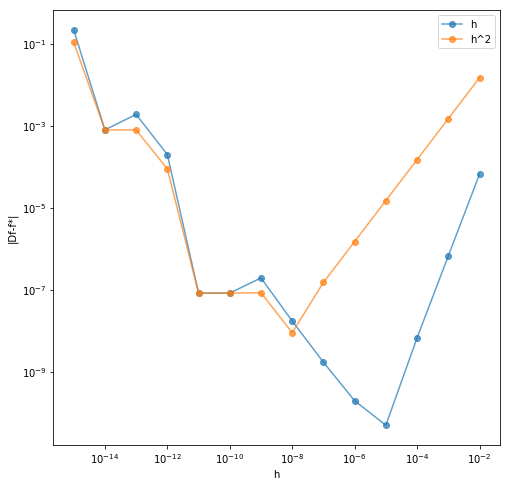

In [56]:
h = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
x = 1
D = []
D_2 = []
for i in h:
    D.append(abs(fder(x) - deriv(f, x, i)))
    D_2.append(abs(fder(x) - deriv_2(f, x, i)))

plt.figure(figsize=(8, 8))
plt.plot(h, D, 'o-', alpha=0.7, label='h', color='C0')
plt.plot(h, D_2, 'o-', alpha=0.7, label='h^2', color='C1')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('h')
plt.ylabel('|Df-f*|')
plt.legend()
plt.show()

### Test I.3 

Now try differentiating $x^2 \log(x)$ at $x=0$. Use the three-point one-sided rule. Note that to evaluate the function at zero, you need to special-case this value. Check the scaling of the error with $h$, explain your results. 
(25% of the total grade)

In [50]:
def f(x):
    if x == 0:
        # the limit of $x^2 log(x)$ at $x-> 0$ is zero, even though log(x) is undefined at x=0
        return 0.0
    else:
        return x**2 * log(x)
    
def fder(x):
    if x == 0:
        return 0.0
    else:
        return x*(2*log(x) + 1)
print ('Второй порядок по h:')
x = 0
for h in [1e-2, 1e-3, 1e-4, 1e-5]:
    err = deriv(f, x, h) - fder(x)
    print("%5f -- %7.4g" % (h, err))
print ('Первый порядок по h:')
x = 0
for h in [1e-2, 1e-3, 1e-4, 1e-5]:
    err = deriv_2(f, x, h) - fder(x)
    print("%5f -- %7.4g" % (h, err))

Второй порядок по h:
0.010000 -- -0.01386
0.001000 -- -0.001386
0.000100 -- -0.0001386
0.000010 -- -1.386e-05
Первый порядок по h:
0.010000 -- -0.04605
0.001000 -- -0.006908
0.000100 -- -0.000921
0.000010 -- -0.0001151


Нет разницы как и ожидалось

# Part II. Midpoint rule 

Write a function which computes a definite integral using the midpoint rule up to a given error, $\epsilon$. Estimate the error by comparing the estimates of the integral at $N$ and $2N$ elementary intervals. 

In [44]:
def midpoint_rule(func, a, b, eps):
    """ Calculate the integral of f from a to b using the midpoint rule.
    
    Parameters
    ----------
    func : callable
        The function to integrate.
    a : float
        The lower limit of integration.
    b : float
        The upper limit of integration.
    eps : float
        The target accuracy of the estimate.
        
    Returns
    -------
    integral : float
        The estimate of $\int_a^b f(x) dx$.
    """
    N=2
    dx=(b-a)/(N-1)/2
    x=np.linspace(a+dx,b-dx,N-1)
    I=(b-a)/(N-1)*np.sum(func(x))
    err=float("inf")
    while (err>eps):
        I_0=I
        N*=2
        dx=(b-a)/(N-1)/2
        x=np.linspace(a+dx,b-dx,N-1)
        I=(b-a)/(N-1)*np.sum(func(x))
        err=np.abs(I-I_0)
    return (I,N)
    

### Test II.1

Test your midpoint rule on a simple integral, which you can calculate by paper and pencil.

Compare the rate of convergence to the expected $O(N^{-2})$ scaling by studying the number of intervals required for a given accuracy $\epsilon$.

Compare the numerical results to the value you calculated by hand. Does the deviation agree with your estimate of the numerical error?
(20% of the total grade)


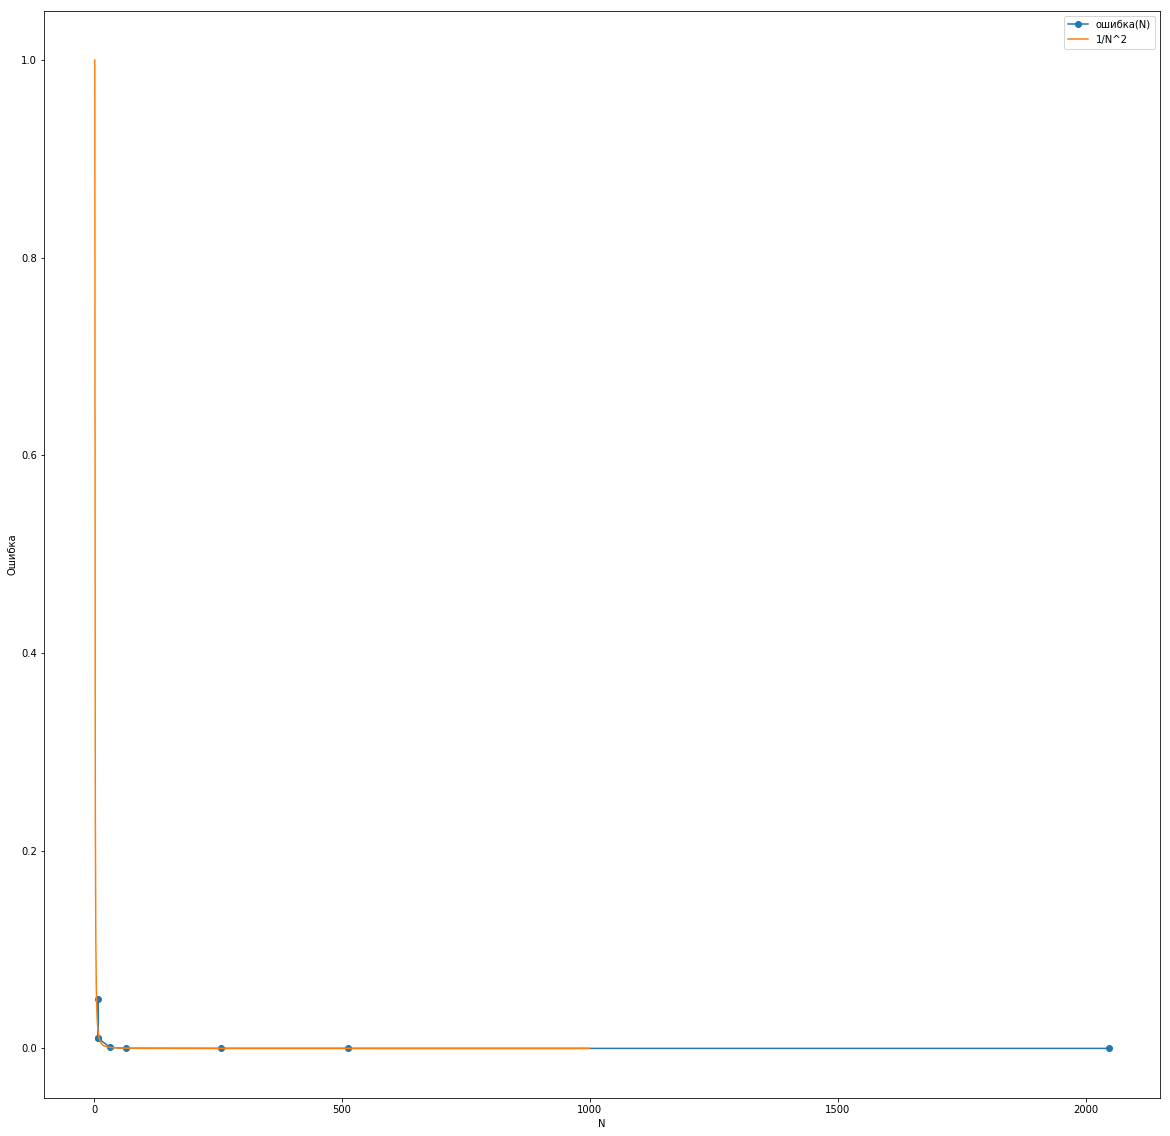

In [77]:
def func(x):
    return x**2

midpoint_rule(func, a=0, b=1, eps=1/10000)
eps=[ 0.01, 0.05, 10**(-2),10**(-3),10**(-4),10**(-5),10**(-6),10**(-7)]
N=[]
for i in eps:
    I, n = midpoint_rule(func, a=0, b=1, eps=i)
    N.append(n)
y=[]  
x=[]
for i in range(1,1000):
    y.append(i**(-2))  
    x.append(i)
        
plt.figure(figsize=(20, 20))
plt.plot(N, epsilon, 'o-' , label='ошибка(N)')
plt.plot(x, y, '-',label='1/N^2')
plt.xlabel('N')
plt.ylabel('Ошибка')
plt.legend()
plt.show()


Оба графика хорошо ложатся друг на друга

### Test II.2

Now use your midpoint rule to compute the value of

$$
\int_0^1\! \frac{\sin{\sqrt{x}}}{x}\, dx
$$

up to a predefined accuracy of $\epsilon=10^{-4}$.

Note that the integral contains an integrable singularity at the lower limit. Do calculations two ways: first, do a straightforward computation; next, subtract the singularity. Compare the number of iterations required to achieve the accuracy of $\epsilon$.

(30% of the total grade)

In [61]:
def func(x):
    return np.sin(np.sqrt(x))/x

def func1(x):
    return func(x)-np.sqrt(1/x)

def func2(x):
    return np.sqrt(1/x)

In [65]:
print(midpoint_rule(func, 0, 1, 1e-4)[0])
print(midpoint_rule(func1, 0, 1, 1e-4)[0]+midpoint_rule(func2, 0, 1, 1e-4)[0])

1.8919572891918648
1.8919377480157564


Очень близкое значения